In [ ]:
pip install spotipy --user

In [ ]:
pip install librosa --user

In [ ]:
pip install pydub --user

In [54]:
import spotipy
import pandas as pd
import numpy as np
import json
import os
import time
import librosa
import io
import pydub
import random
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from spotipy.oauth2 import SpotifyClientCredentials
from urllib.request import urlopen
from collections import Counter

In [6]:
def get_credentials(api_cred_fp):
    if os.path.exists(api_cred_fp):
        with open(api_cred_fp) as json_file:
            creds = json.load(json_file)
        return creds
    else:
        "Credentials File Not Found"

In [4]:
def get_features(cred_dir,data_dir):
    creds = get_credentials(cred_dir)
    
    client_id = creds['client_id']
    client_secret = creds['client_secret']
    
    df = pd.read_csv(data_dir)
    
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    all_features = []
    all_labels = []
    
    wav = io.BytesIO()
    for ix,row in df.iterrows():
        song_id = row['id']
        if song_id not in ids:
            track = spotify.track(song_id)
            url  = track['preview_url']
            if url!=None:
                with urlopen(url) as r:
                    r.seek = lambda *args: None
                    pydub.AudioSegment.from_file(r).export(wav, "wav")

                wav.seek(0)
                y, sr = librosa.load(wav)
                features = librosa.feature.mfcc(y, sr=sr)
                features = features.T
                label = [row['genre(s)']]
                all_labels = np.concatenate((all_labels,label*len(features))) 
    
                if len(all_features) == 0:
                    all_features = features
                else:
                    all_features = np.vstack((all_features,features))
    return all_features, all_labels,df,spotify

In [46]:
def get_model_metrics(spotify,df,model,genre,sample_size):
    ids = random.choices(df[df['genre(s)']==genre].id.values,k=sample_size*2)
    pred_results = []
    wav = io.BytesIO()
    for i in ids:
        track = spotify.track(i)
        url  = track['preview_url']
        if url!=None:
            with urlopen(url) as r:
                r.seek = lambda *args: None
                pydub.AudioSegment.from_file(r).export(wav, "wav")

            wav.seek(0)
            y, sr = librosa.load(wav)
            features = librosa.feature.mfcc(y, sr=sr)
            features = features.T
    
            pred_label = model.predict(features)
            pred_label = dict(Counter(pred_label))
            pred_results.append(max(pred_label, key=pred_label.get))
        if len(pred_results)==sample_size:
            break
            
    return pred_results

In [6]:
def generate_training_data(all_features,all_labels,genre,set_size=100000):
    randomize_placeholder = list(zip(all_features, all_labels))
    random.shuffle(randomize_placeholder)
    all_features, all_labels = zip(*randomize_placeholder)
    del randomize_placeholder
    genre_removed_features = []
    genre_removed_labels = []
    for feature,label in zip(all_features, all_labels):
        if (len(genre_removed_features)!=set_size) and (genre not in label):
            genre_removed_features.append(feature)
            genre_removed_labels.append(label)
    return genre_removed_features,genre_removed_labels

In [7]:
def train_models(test_features,test_labels):
    randForestModel = RandomForestClassifier()
    KNNmodel = KNeighborsClassifier()
    
    randForestModel.fit(test_features,test_labels)
    KNNmodel.fit(test_features,test_labels)
    return randForestModel,KNNmodel

### Generate Features from DataFrame

In [ ]:
data_dir = '../data/test/all/metadata/all_audio_features.csv'
cred_dir = '../api_cred.json'

In [ ]:
all_features, all_labels,df,spotify = get_features(cred_dir,data_dir)

### Exclude K-pop entries and get sample of all features for training features

In [ ]:
training_features,training_labels = generate_training_data(all_features,all_labels,'kpop')

### Train models

In [ ]:
randForestModel,KNNmodel = train_models(training_features,training_labels)

### Predict random K-pop song genre with models

In [ ]:
res_rand = get_model_metrics(spotify,df,randForestModel,'kpop',2500)

In [ ]:
res_KNN = get_model_metrics(spotify,df,KNNmodel,'kpop',2500)

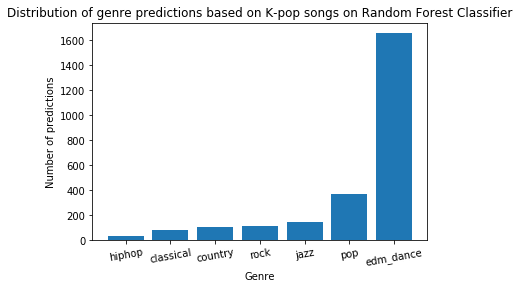

In [69]:
res_rand = {k: v for k, v in sorted(dict(Counter(res_rand)).items(), key=lambda item: item[1])}
plt.bar(res_rand.keys(),res_rand.values())
plt.xlabel('Genre')
plt.ylabel('Number of predictions')
plt.title('Distribution of genre predictions based on K-pop songs on Random Forest Classifier')
plt.xticks(rotation=10)
plt.show()

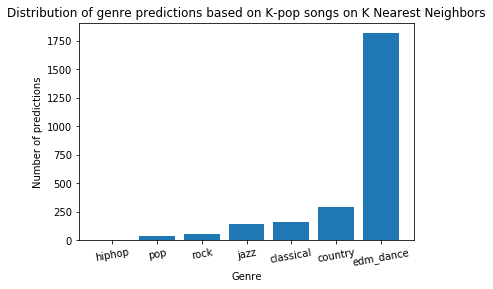

In [68]:
res_KNN = {k: v for k, v in sorted(dict(Counter(res_KNN)).items(), key=lambda item: item[1])}
plt.bar(res_KNN.keys(),res_KNN.values())
plt.xlabel('Genre')
plt.ylabel('Number of predictions')
plt.title('Distribution of genre predictions based on K-pop songs on K Nearest Neighbors')
plt.xticks(rotation=10)
plt.show()